In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
prediction_path = '/root/cervical_spine/third/yolov7_custom/runs/train/yolov7-custom18/predictions.csv'

In [3]:
columns = ['UID'] + [f'P{i}' for i in range(8)] + ['loss','loss_pos','loss_neg'] + [f'C{i}' for i in range(8)] 
patient_pred_df = pd.read_csv(prediction_path, names=columns)

patient_pred_df

,UID,P0,P1,P2,P3,P4,P5,P6,P7,loss,loss_pos,loss_neg,C0,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,0.064511,0.010000,0.010000,0.010000,0.010000,0.010000,0.010093,0.064511,0.042420,0.000000,0.042420,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10005,0.011837,0.010000,0.010000,0.010000,0.010000,0.010000,0.011837,0.010000,0.011112,0.000000,0.011112,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10014,0.156892,0.010000,0.010000,0.010000,0.067953,0.156892,0.010000,0.017696,0.106694,0.000000,0.106694,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10016,0.044408,0.010000,0.010000,0.010000,0.010000,0.027414,0.044408,0.010000,2.405660,3.300693,0.018904,1,0,1,0,0,0,0,0
4,1.2.826.0.1.3680043.10032,0.077232,0.012047,0.010000,0.010000,0.010000,0.010000,0.077232,0.013607,0.050646,0.000000,0.050646,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1.2.826.0.1.3680043.11515,0.217643,0.217643,0.101687,0.046337,0.010000,0.010000,0.010000,0.010000,0.154174,0.000000,0.154174,0,0,0,0,0,0,0,0
76,1.2.826.0.1.3680043.11605,0.027117,0.027117,0.010000,0.010000,0.018055,0.010000,0.010000,0.010000,2.664212,3.658432,0.012957,1,0,0,0,1,0,0,0
77,1.2.826.0.1.3680043.11606,0.898416,0.349780,0.095787,0.010000,0.013504,0.898416,0.010000,0.010000,0.548316,0.651260,0.033597,1,1,0,1,0,1,0,0
78,1.2.826.0.1.3680043.11610,0.011048,0.010000,0.010000,0.010000,0.010000,0.010000,0.011048,0.010000,0.010656,0.000000,0.010656,0,0,0,0,0,0,0,0


In [4]:
# patient_pred_df = pd.read_csv('/root/autodl-tmp/df_patient_pred_7945.csv',header = 0, names=['StudyInstanceUID'] + [f'P{i}' for i in range(8)]).set_index('StudyInstanceUID')
# label_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('StudyInstanceUID')
# # patient_pred_df.rename(columns = {"patient_overall" : "UID"}, inplace = True)

# label_df.rename(columns = {"patient_overall" : "C0"}, inplace = True)
# patient_pred_df = pd.concat((patient_pred_df, label_df), axis=1)
# patient_pred_df = patient_pred_df[~pd.isna(patient_pred_df['P0'])]
# patient_pred_df

In [5]:
def cal_loss(prob, label):
    
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum() / weight_total.sum()

In [6]:
prob = patient_pred_df[[f'P{i}' for i in range(8)]].values
label = patient_pred_df[[f'C{i}' for i in range(8)]].values

In [7]:
loss = cal_loss(prob, label)
print('baseline:', loss)

baseline: 0.4747504342995239


min loss: 0.43851997650584823


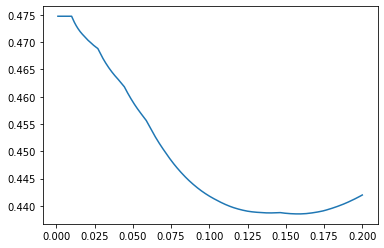

In [8]:
# only clip lower bound
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=clip, a_max=1)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)

min loss: 0.47470621787495965


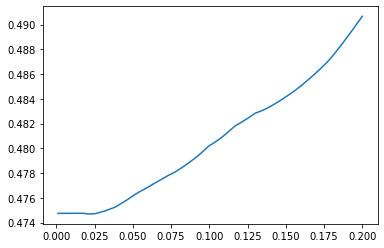

In [9]:
# clip upper
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=0, a_max=1-clip)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)

In [10]:
# clip both
losses = []

min_clips = np.linspace(0.001, 0.2, 200)
max_clips = np.linspace(0.001, 0.2, 200)

for min_clip in tqdm(min_clips):
    
    for max_clip in max_clips:
        new_prob = np.clip(prob, a_min=min_clip, a_max=1-max_clip)
        loss= cal_loss(new_prob, label)
    
        losses.append(loss)
print('min loss:', np.min(losses))
# plt.plot(clips, losses)

100%|██████████| 200/200 [00:01<00:00, 119.63it/s]

min loss: 0.4384758119517357
